# Transformada de distancia

[wikipedia](https://en.wikipedia.org/wiki/Distance_transform)

Muchas tareas de procesamiento de imagen pueden atacarse de forma sencilla si se conoce la distancia de cualquier pixel de la imagen al punto más próximo de una determinada región $R$. En principio esto parece computacionalmente muy costoso, ya que exige calcular $N\times M$ distancias, siendo $N$ el número de pixels de interés en la imagen y $M$ el de los que pertenecen a $R$. Si nos interesa la imagen completa este número es enorme. Afortunadamente, existen [algoritmos](https://www.springer.com/cda/content/document/cda_downloaddocument/9780387312019-c1.pdf) muy eficientes para calcular la distancia de todos los puntos de la imagen. Por ejemplo, es posible calcular la transformada de distancia euclídea (aproximada) mediante solo dos pasadas por la imagen ([Borgefors](https://www.realestatetrading.com/storage/documents/Borgefors86__Work.pdf)).

In [1]:
%matplotlib inline

import numpy             as np
import cv2               as cv
import matplotlib.pyplot as plt

Veamos un ejemplo con la implementación de la transformada de distancia Euclídea exacta proporcionada por scipy.

Creamos una imagen  de prueba con tres "objetos":

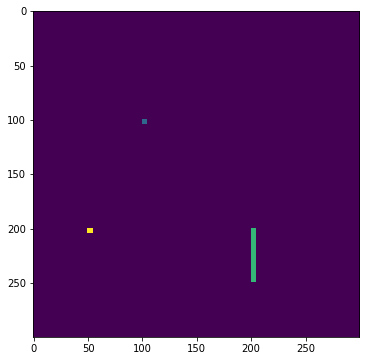

In [2]:
from scipy.ndimage.morphology import distance_transform_edt

plt.figure(figsize=(6,6))
x = np.zeros([300,300])
x[100:105,100:105] = 1
x[200:250,200:205] = 2
x[200:205,50:55] = 3

plt.imshow(x,interpolation=None);

El convenio de esta función es que la región "objeto" $R$ tiene valor *False* (o cero). En ellos la distancia será cero. La función calcula la distancia en los pixels *True* (o mayores que cero).

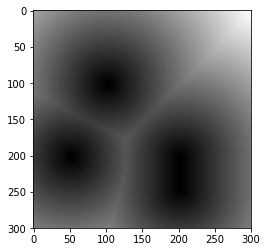

In [3]:
d = distance_transform_edt(x==0)

plt.imshow(d, 'gray');

Además de la distancia, podemos pedir el pixel concreto más cercano. Esto nos permite segmentar la imagen en regiones de mayor proximidad. El truco para conseguir la representacion siguiente es marcar cada región con un número distinto.

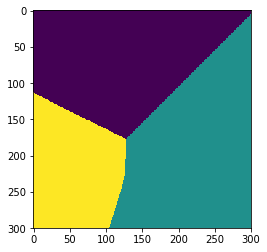

In [4]:
d,idxs = distance_transform_edt(x==0,return_indices=True)
idxs.shape

plt.imshow(x[idxs[0],idxs[1]]);

## Esqueleto de una figura

Ahora vamos a aplicar la transformada para calcular la distancia desde dentro de una región hasta el exterior.

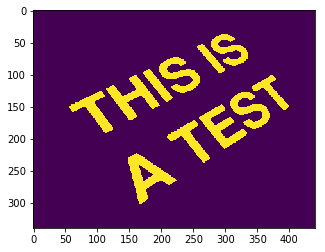

In [5]:
img = cv.imread('../images/contours.png')
g   = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
x = (g < 128)[10:350, 10:450]

plt.imshow(x);

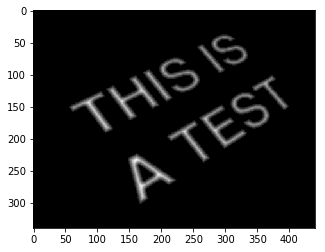

In [6]:
d = distance_transform_edt(x)

plt.imshow(d, 'gray');

Ampliamos un poco, y vemos como las zonas de máxima distancia se encuentran en la zona central de cada trozo:

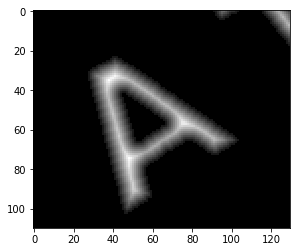

In [7]:
plt.imshow(d[200:310,120:250], 'gray');

El [skeleton](http://scikit-image.org/docs/0.10.x/auto_examples/plot_medial_transform.html) de la figura es el conjunto de puntos que tienen al menos dos puntos frontera a la máxima distancia. Está implementado en *skimage*.

In [8]:
from skimage.morphology import medial_axis

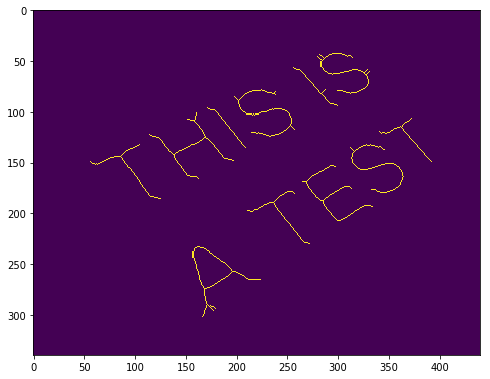

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(medial_axis(x.astype(np.uint8)),interpolation='nearest');

## Separación de estructuras convexas solapadas

La siguiente imagen procede de una segmentación por color de una escena en la que hay numerosos objetos redondeados. Si estuvieran perfectamente separados se podrían identificar fácilmente mediante un sencillo etiquetado de componentes conexas. Al estar muchos de ellos pegados esto no funciona.

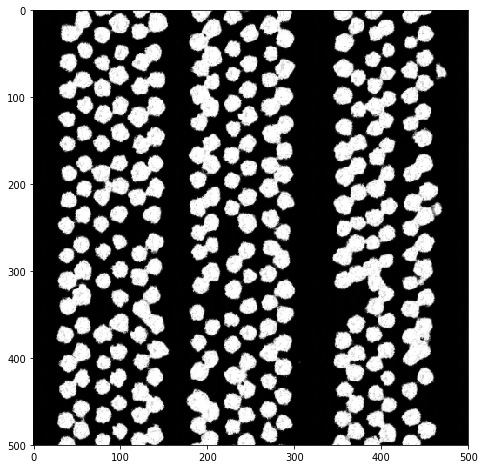

In [10]:
img = cv.imread('../images/segm.png')
bw = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

plt.figure(figsize=(8,8))
plt.imshow(bw,'gray');

Para este tipo de problema la transformada de distancia es muy útil. En este ejemplo usamos la implementación de OpenCV, que nos pide el tipo de distancia y el tamaño de una máscara auxiliar. La image de entrada debe ser de tipo *byte*, y de nuevo los puntos del fondo, con valor cero, son la región respecto a la cual se calcula la distancia. Mostramos un fragmento ampliado del resultado:

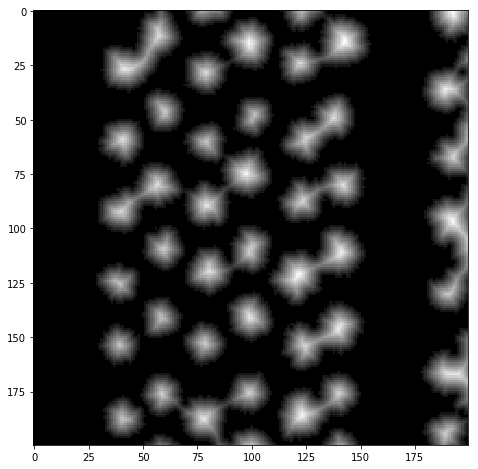

In [11]:
plt.figure(figsize=(8,8))
td = cv.distanceTransform( (bw > 32).astype(np.uint8) , cv.DIST_L2, 5)
plt.imshow(td[:200,:200],'gray');

Se observa que los máximos de distancia están cerca del centro de cada mancha aunque haya objetos solapados: los estrechamientos producen picos de distancia claramente distintos. Estos picos pueden detectarse con una operación de "supresión de no máximos" (*nonmaxima supression (nms)*), que sea capaz de detectar máximos locales. Una forma simple de implementar esta operación consiste en comparar la imagen con un filtro de máximo de ella misma. Los máximos locales tendrán un valor igual al del máximo de sus vecinos. (Este método no es perfecto porque no tiene en cuenta posibles empates.)

In [12]:
def nms(x, t = 0.1):
    m = cv.dilate(x, np.ones((5,5),np.uint8))  # filtro de máximo implementado como dilatación
    h = np.max(m)
    return (x == m) & (x > t*h)

Una idea que parece funcionar bastante bien consiste en suavizar ligeramente la imagen de entrada (con la idea de redondear los bordes), binarizar con un umbral razonable para crear la imagen de entrada, y calcular un suavizado final de la transformada de distancia para deshacer posibles empates, dejando pixels individuales como centros de los objetos detectados.

In [13]:
S1 = 1
H  = 32 
S2 = 1

dist = cv.GaussianBlur(cv.distanceTransform((cv.GaussianBlur(bw,(0,0),S1) > H).astype(np.uint8), cv.DIST_L2, 3),(0,0),S2)

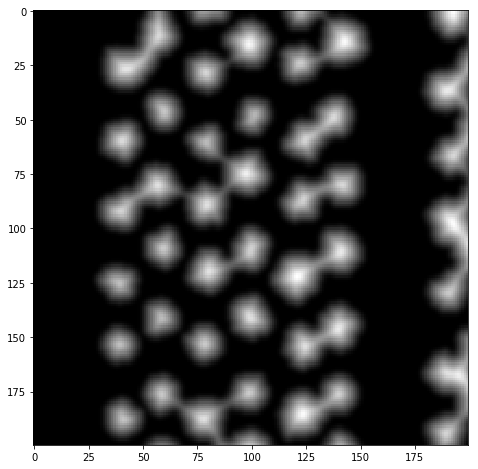

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(dist[:200,:200],'gray');

Extraemos los máximos locales con nms, que produce una imagen booleana, y de ella extraemos las coordenadas de los extremos. El tamaño del cada objeto nos lo da precisamente el valor de la transformada de distancia en los extremos. Correspondería al radio si el objeto fuera perfectamente circular.

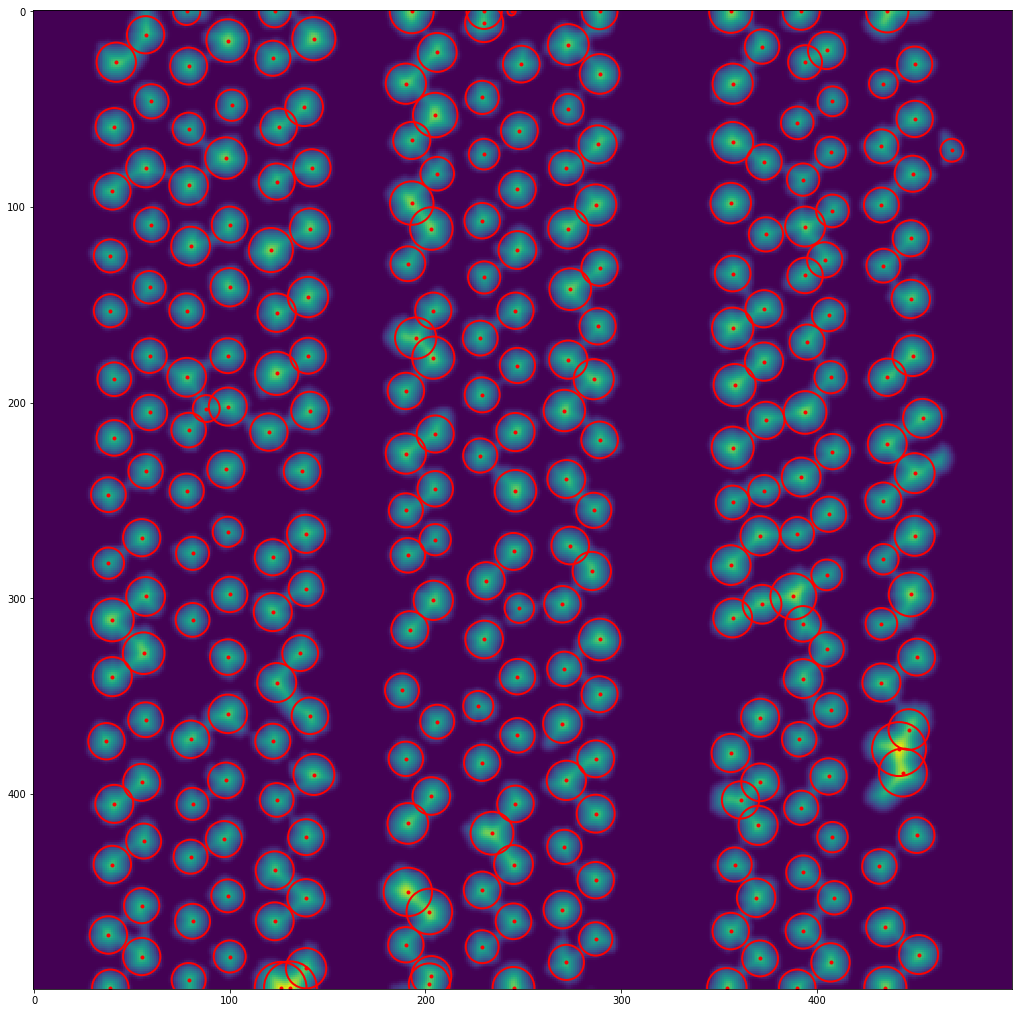

In [15]:
points = nms(dist)

py,px = np.where(points)

plt.figure(figsize=(18,18))
plt.imshow(dist); 
#plt.imshow(img,'gray')

plt.plot(px,py,'.',color='red');

ax = plt.gca()

for x,y in zip(px,py):
    ax.add_patch(plt.Circle((x,y),dist[y,x],color='red',fill=False,lw=2));

[watershed]: https://en.wikipedia.org/wiki/Watershed_(image_processing)

Finalmente podemos comparar esta segmentación circular con el resultado obtenido por la técnica [watershed][watershed], que parte de "semillas" (en nuestro caso usamos los extremos de distancia) y va extendiendo las regiones hasta que se toquen, creando algo análogo a las cuencas hidrográficas.

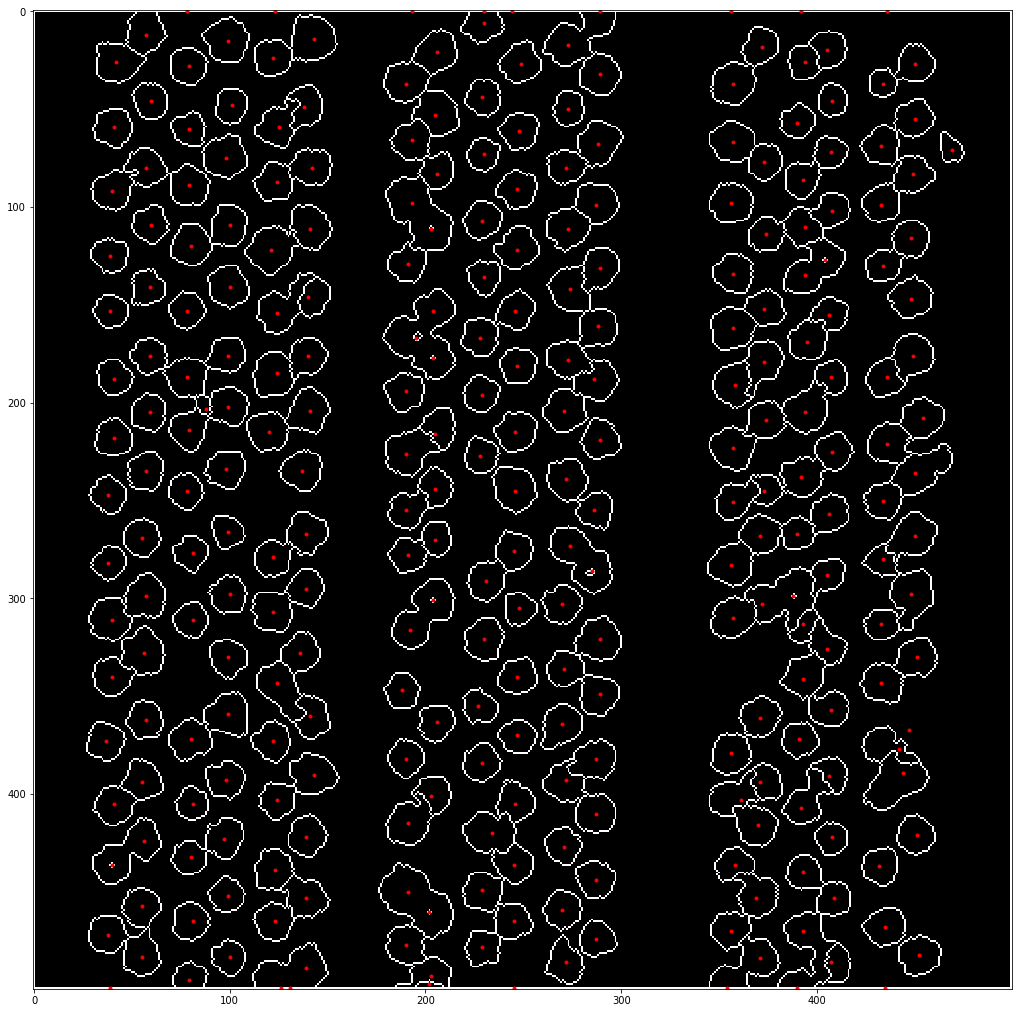

In [16]:
plt.figure(figsize=(18,18))
ws = cv.watershed(img,cv.connectedComponents(points.astype(np.uint8))[-1])
plt.imshow(ws==-1,'gray');
plt.plot(px,py,'.',color='red');

## Hausdorff distance

## Signed distance transform